In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox  # 白噪声检验
import statsmodels.tsa.stattools as st
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA

In [3]:
class Arima:
    def __init__(self, data, n):
        """
            :param data: Series/np/list
            :param n: 预测数量
        """
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        if isinstance(data, pd.Series):
            self.data = data.values
        elif isinstance(data, np.ndarray):
            self.data = data
        elif isinstance(data, list):
            self.data = np.array(data)
        self.check()
        self.pre_model()
        self.build_model(n)
        print("返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图\n", self.res_df)

    def check(self):
        series = pd.Series(self.data.reshape(-1))
        # 平稳性ADF检验
        print('+++++++++++++++++++++++++++++++++开始进行平稳性ADF检验+++++++++++++++++++++++++++++++')
        d = 0
        while (True):
            if (d > 0):
                series = series.diff(1)
                series = series.dropna(how=any)
            t = sm.tsa.stattools.adfuller(series, )
            output = pd.DataFrame(
                index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                       "Critical Value(1%)",
                       "Critical Value(5%)", "Critical Value(10%)"], columns=['value'])
            output['value']['Test Statistic Value'] = t[0]
            output['value']['p-value'] = t[1]
            output['value']['Lags Used'] = t[2]
            output['value']['Number of Observations Used'] = t[3]
            output['value']['Critical Value(1%)'] = t[4]['1%']
            output['value']['Critical Value(5%)'] = t[4]['5%']
            output['value']['Critical Value(10%)'] = t[4]['10%']
            print(output)
            if t[1] > 0.05:
                print(f'单位根检验中p值为{t[1]}，大于0.05，为非平稳序列,进行{d + 1}阶差分')
                d += 1
            else:
                print('单位根检验中p值为%.2f，小于0.05，为平稳序列' % (t[1]))
                self.d = d
                break
        print(f'++++++++++++++++++++++++++ADF检验完成，{d}阶差分后已为平稳序列+++++++++++++++++++++++++++++++')
        print(f'++++++++++++++++++++++++++开始白噪声检验+++++++++++++++++++++++++++++++')
        noiseP = acorr_ljungbox(series, lags=1)[-1]
        if noiseP <= 0.05:
            print('白噪声检验中p值为%.2f，小于0.05，为非白噪声' % noiseP)
        else:
            print('白噪声检验中%.2f，大于0.05，为白噪声' % noiseP)
        print(f'++++++++++++++++++++++++++白噪声检验完成+++++++++++++++++++++++++++++++')
        self.data_diff = series

    def pre_model(self):
        series = self.data_diff
        self.time_plot(series)
        import warnings
        warnings.filterwarnings("ignore")
        pMax = int(series.shape[0] / 10)  # 一般阶数不超过length/10
        qMax = pMax  # 一般阶数不超过length/10
        order = st.arma_order_select_ic(series, max_ar=pMax, max_ma=qMax, ic=['aic', 'bic', 'hqic'])
        p, q = order.aic_min_order
        print('AIC准则下确定p,q为%s,%s' % (p, q))
        p, q = order.bic_min_order
        print('BIC准则下确定p,q为%s,%s' % (p, q))
        self.q = q
        self.p = p

    # 借助AIC、BIC统计量自动确定p,q
    def build_model(self, n):
        print(f'++++++++++++++++++++++++++开始建立ARIMA模型+++++++++++++++++++++++++++++++')
        series = pd.Series(self.data.reshape(-1))
        print('ARIMA建模使用参数：p=%s,d=%s,q=%s' % (self.p, self.d, self.q))
        model = ARIMA(series, order=(self.p, self.d, self.q)).fit()
        predict_n = model.forecast(n)[0]
        print(model.summary())

        fit_v = model.fittedvalues
        for _ in range(self.d):
            fit_v = fit_v.cumsum()
        fit_v += series[0]
        fit_res = [series[0]]
        fit_res.extend(x for x in fit_v)
        fit_res.extend(x for x in predict_n)

        delta = [np.nan]
        delta.extend(x for x in model.resid)
        self.res_df = pd.concat([pd.DataFrame({'原始值': self.data}), pd.DataFrame({'预测值': fit_res}),
                                 pd.DataFrame({'残差': delta}),
                                 pd.DataFrame({'相对误差': list(map(lambda x: '{:.2%}'.format(x), np.abs(delta / self.data)))})
                                 ], axis=1)
        self.verify(model.resid)

    # 模型验证，针对残差
    def verify(self, resid):
        print(f'++++++++++++++++++++++++++开始模型验证+++++++++++++++++++++++++++++++')
        t = sm.tsa.stattools.adfuller(resid, )
        output = pd.DataFrame(
            index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                   "Critical Value(1%)",
                   "Critical Value(5%)", "Critical Value(10%)"], columns=['value'])
        output['value']['Test Statistic Value'] = t[0]
        output['value']['p-value'] = t[1]
        output['value']['Lags Used'] = t[2]
        output['value']['Number of Observations Used'] = t[3]
        output['value']['Critical Value(1%)'] = t[4]['1%']
        output['value']['Critical Value(5%)'] = t[4]['5%']
        output['value']['Critical Value(10%)'] = t[4]['10%']
        print(output)
        resid = pd.Series(resid)
        self.time_plot(resid, title='ARIMA残差')

    def time_plot(self, series, title=''):
        plt.rcParams['font.sans-serif'] = ['SimHei']
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        series.plot(ax=ts_ax)
        ts_ax.set_title(f'{title}时序图')
        plot_acf(series, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
#         plot_pacf(series.values, ax=pacf_ax, nlags=series.shape[0]-2,alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(series, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')
        scs.probplot(series, sparams=(series.mean(),
                                      series.std()), plot=pp_ax)
        pp_ax.set_title('PP 图')
        plt.tight_layout()
        plt.show()

    def plot_res(self, xlabel='', ylabel=''):
        res_df = self.res_df
        f, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(x=res_df.index.tolist(), y=res_df['预测值'], linewidth=2, ax=ax)
        sns.scatterplot(x=res_df.index.tolist(), y=res_df['原始值'], s=60, color='r', marker='v', ax=ax)
        plt.fill_between(np.where(np.isnan(res_df["原始值"]))[0], y1=min(plt.yticks()[0]), y2=max(plt.yticks()[0]),
                         color='orange', alpha=0.2)
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        plt.show()


偏自相关性图注释掉了，有bug还是怎么地 画不出来

In [4]:
df=pd.read_csv(r'../ym_num.csv')

In [5]:
df

,y-m,0
0,2015-1,4012
1,2015-2,3761
2,2015-3,3660
3,2015-4,3532
4,2016-1,3460
5,2016-2,3629
6,2016-3,3321
7,2016-4,3177
8,2017-1,2719
9,2017-2,3023


+++++++++++++++++++++++++++++++++开始进行平稳性ADF检验+++++++++++++++++++++++++++++++
                               value
Test Statistic Value          3.7166
p-value                            1
Lags Used                          4
Number of Observations Used        7
Critical Value(1%)          -4.93869
Critical Value(5%)          -3.47758
Critical Value(10%)         -2.84387
单位根检验中p值为1.0，大于0.05，为非平稳序列,进行1阶差分
                                value
Test Statistic Value         -3.98249
p-value                      0.001505
Lags Used                           0
Number of Observations Used        10
Critical Value(1%)           -4.33157
Critical Value(5%)           -3.23295
Critical Value(10%)           -2.7487
单位根检验中p值为0.00，小于0.05，为平稳序列
++++++++++++++++++++++++++ADF检验完成，1阶差分后已为平稳序列+++++++++++++++++++++++++++++++
++++++++++++++++++++++++++开始白噪声检验+++++++++++++++++++++++++++++++
白噪声检验中0.20，大于0.05，为白噪声
++++++++++++++++++++++++++白噪声检验完成+++++++++++++++++++++++++++++++


E:\ANACONDA\envs\mathmodel\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


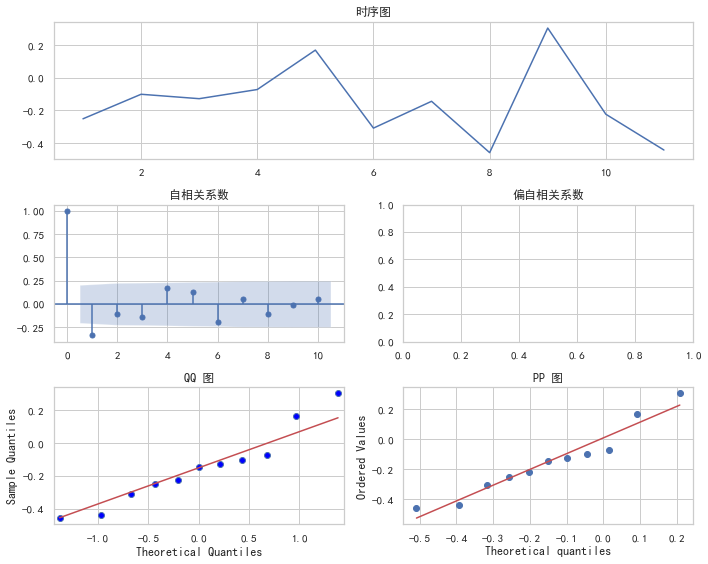

AIC准则下确定p,q为0,1
BIC准则下确定p,q为0,1
++++++++++++++++++++++++++开始建立ARIMA模型+++++++++++++++++++++++++++++++
ARIMA建模使用参数：p=0,d=1,q=1
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   11
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   3.540
Method:                       css-mle   S.D. of innovations              0.157
Date:                Fri, 09 Jul 2021   AIC                             -1.080
Time:                        14:23:06   BIC                              0.114
Sample:                             1   HQIC                            -1.832
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1277      0.013     -9.748      0.000      -0.153      -0.102
ma.L1.

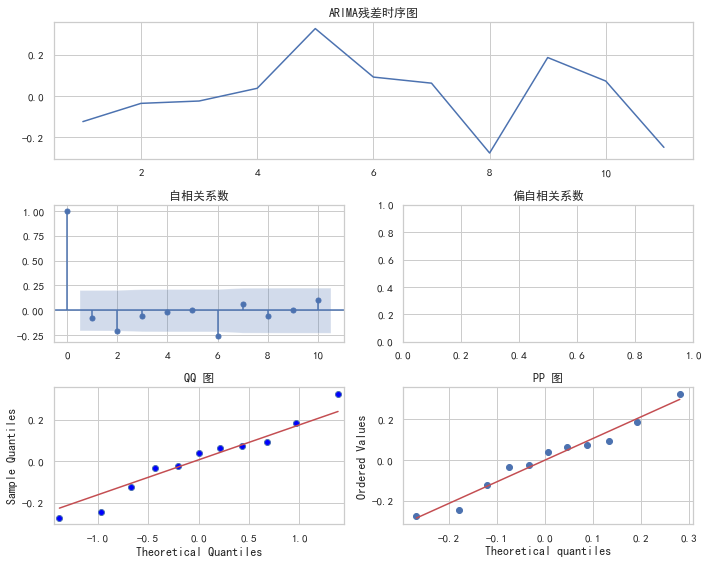

返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图
       原始值       预测值        残差    相对误差
0   4.012  4.012000       NaN    nan%
1   3.761  3.884294 -0.123294   3.28%
2   3.660  3.818234 -0.034941   0.95%
3   3.532  3.713822 -0.023587   0.67%
4   3.460  3.603806  0.038016   1.10%
5   3.629  3.445687  0.327119   9.01%
6   3.321  3.045382  0.092305   2.78%
7   3.177  2.838556  0.062825   1.98%
8   2.719  2.655878 -0.275322  10.13%
9   3.023  2.772902  0.186976   6.19%
10  2.800  2.476918  0.072985   2.61%
11  2.358  2.282862 -0.247944  10.52%
12    NaN  2.478238       NaN     NaN
13    NaN  2.350531       NaN     NaN
14    NaN  2.222825       NaN     NaN
15    NaN  2.095119       NaN     NaN
16    NaN  1.967413       NaN     NaN
17    NaN  1.839706       NaN     NaN
18    NaN  1.712000       NaN     NaN
19    NaN  1.584294       NaN     NaN
20    NaN  1.456587       NaN     NaN
21    NaN  1.328881       NaN     NaN


In [6]:
arima=Arima(df['0']/1000,10)

In [7]:
res_df=arima.res_df

In [8]:
res_df

,原始值,预测值,残差,相对误差
0,4.012,4.012000,NaN,nan%
1,3.761,3.884294,-0.123294,3.28%
2,3.660,3.818234,-0.034941,0.95%
3,3.532,3.713822,-0.023587,0.67%
4,3.460,3.603806,0.038016,1.10%
5,3.629,3.445687,0.327119,9.01%
6,3.321,3.045382,0.092305,2.78%
7,3.177,2.838556,0.062825,1.98%
8,2.719,2.655878,-0.275322,10.13%
9,3.023,2.772902,0.186976,6.19%


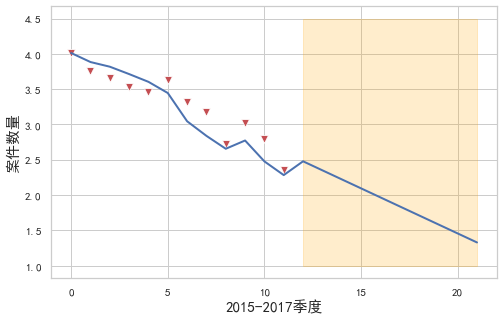

In [22]:
arima.plot_res(xlabel="2015-2017季度",ylabel="案件数量")

In [23]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(res_df['原始值'][:12], res_df['预测值'][:12])
print("ARIMA预测",{"mse": mse,'RMSE':np.sqrt(mse)})

ARIMA预测 {'mse': 0.041221102782066664, 'RMSE': 0.20302980761963663}


In [24]:
a=arima.data_diff



ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 5.

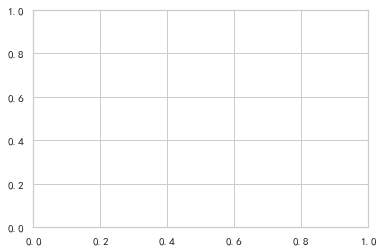

In [25]:
plot_pacf(a)